# Brain-Tumor-Segmentation
- Tutorial following kaggle code from https://www.kaggle.com/code/mohamedabdelaziz187/brain-tumor-segmentation

### Theory Review
- Conv2d Layers
- Back propagation
- ADAM
### Tech to do
- Try preloading encoder
- Load to github

## Import Packages

In [144]:
import pandas as pd
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg16_bn
import torch.nn as nn
import torch.optim as optim

In [3]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_colwidth', 500)

## Create Functions

In [5]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df


## Get Image Directories and Assign Train/Test

In [6]:
data_path = os.getcwd()+'/Kaggle/input/lgg-mri-segmentation/kaggle_3m'
df = create_df(data_path)

In [7]:
df.head(2)

,images_paths,masks_paths
0,/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif,/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif
1,/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif,/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif


In [8]:
train_df, val_df, test_df = split_df(df)

In [9]:
train_df.iloc[1]

images_paths         /Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23.tif
masks_paths     /Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23_mask.tif
Name: 3537, dtype: object

In [10]:
print('Train\t', train_df.shape, '\nVal\t', val_df.shape, '\nTest\t', test_df.shape)

Train	 (3143, 2) 
Val	 (393, 2) 
Test	 (393, 2)


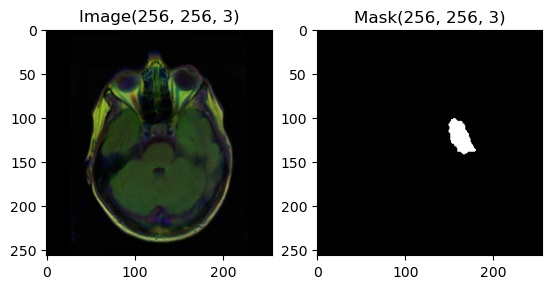

In [23]:
# example with mask
image = cv2.imread('/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
mask = cv2.imread('/Users/hannahdavies/Documents/Training/Image_Segmentation/Kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8_mask.tif')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.0 #Not needed as actually b&w but for consistency
mask = np.where(mask>=0.5, 1., 0.)

#kaggle notebook no problems with RGB/BGR

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()

## Create Dataset

In [99]:
# similar to tensorflow will execute operations later?
# using dataloader lets you iterate through each idx?

class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.0 
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

In [100]:
train_data = Brain_mri_dataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = Brain_mri_dataset(test_df, transform = transform_ ,  mask_transform= transform_)

In [101]:
train_data

In [102]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

In [103]:
train_dataloader

In [104]:
print('Training batches\t', len(train_dataloader))
print('Validation batches\t', len(val_dataloader))
print('Test batches\t\t', len(test_dataloader))

Training batches	 50
Validation batches	 7
Test batches		 7


In [105]:
# ([batch_size, channels, H, W]) - contains all images for 1 batch
img_sample, msk_sample = next(iter(val_dataloader))
print(img_sample.shape, '\t', img_sample.dtype)
print(msk_sample.shape, '\t', msk_sample.dtype)

torch.Size([64, 3, 256, 256]) 	 torch.float64
torch.Size([64, 3, 256, 256]) 	 torch.float64


In [106]:
img_sample[0].shape

torch.Size([3, 256, 256])

In [107]:
img_sample[0].permute(1,2,0).shape

torch.Size([256, 256, 3])

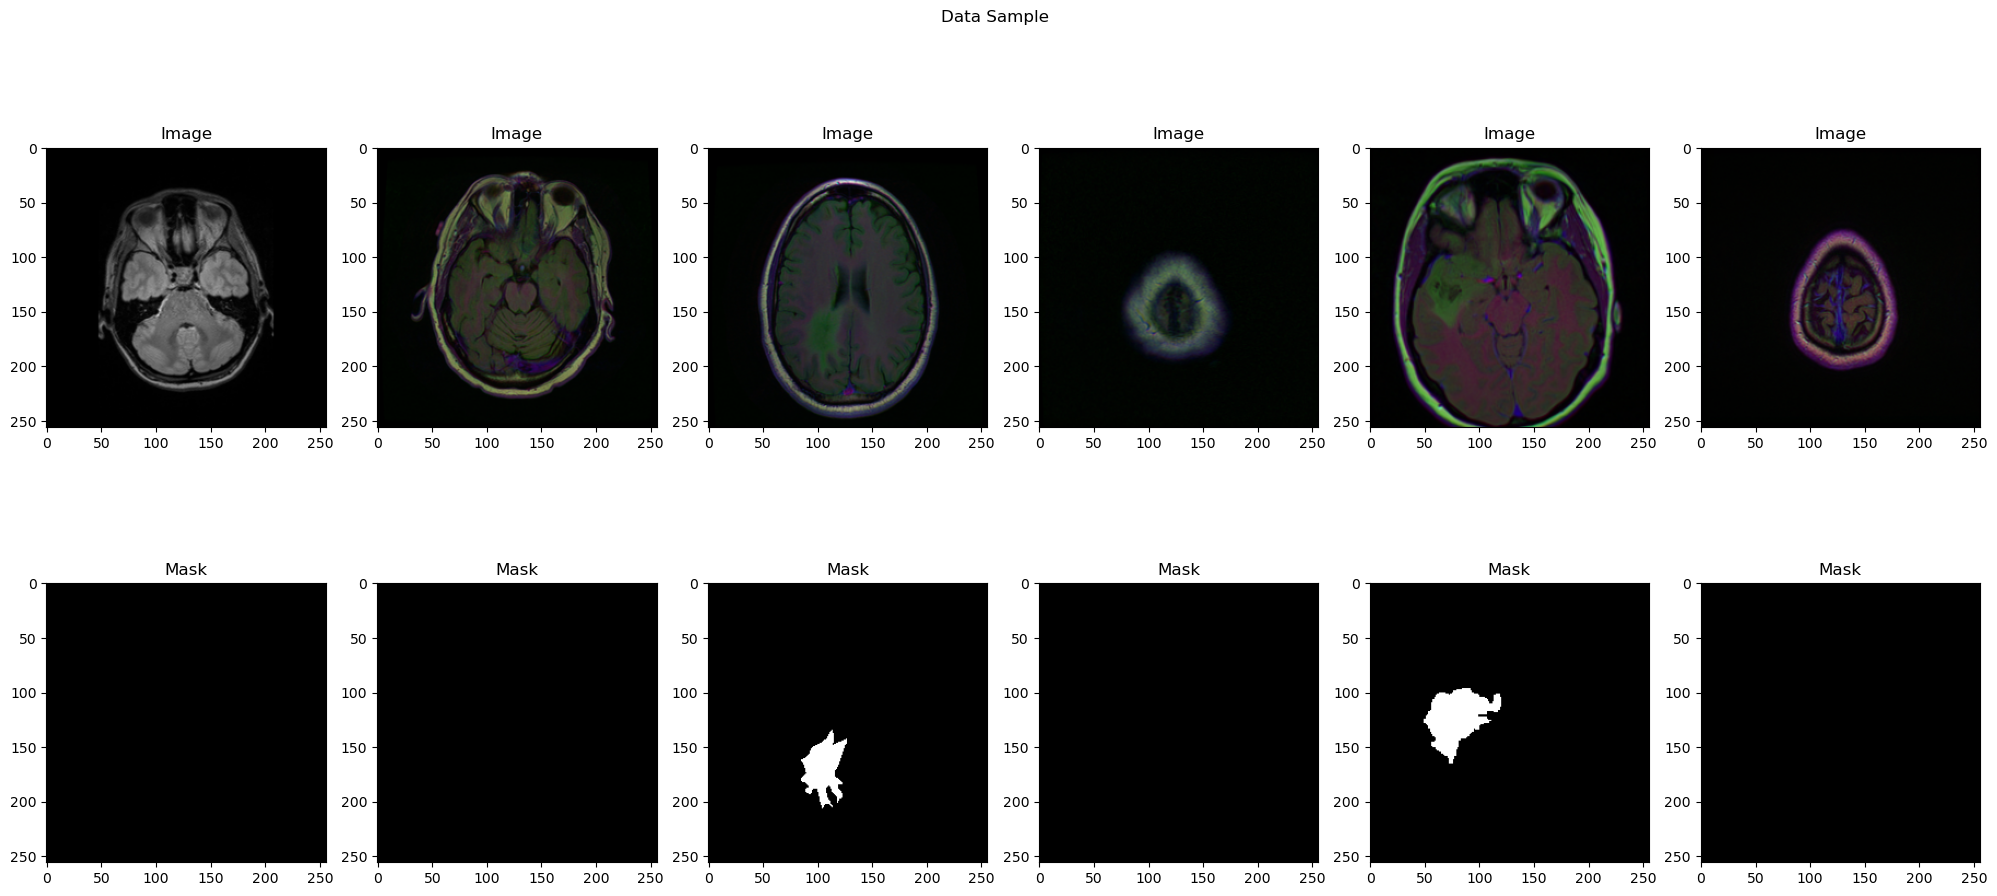

In [108]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i in range(6):
  axs[0, i].imshow(img_sample[i].permute(1,2,0))
  axs[0, i].set_title("Image")

  axs[1, i].imshow(msk_sample[i].permute(1,2,0))
  axs[1, i].set_title("Mask")
fig.suptitle('Data Sample')
fig.tight_layout()
fig.show()

## Define U-net architecture

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [118]:
class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__() #UNet inherits from nn.Module class
       #since the init method of UNet is super(UNet, self)__init__() is will inherit the same init function as nn.Module (next class in MRO)

       # Encoder
       self.encoder1 = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True)
       )
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True)
       )
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder3 = nn.Sequential(
           nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True)
       )
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder4 = nn.Sequential(
           nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True)
       )
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


       # Bottleneck
       self.bottleneck = nn.Sequential(
           nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
       )

       # Decoder
       self.upconv4 = nn.Sequential(
           nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder4 = nn.Sequential(
           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh(),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh()
       )
       self.upconv3 = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder3 = nn.Sequential(
           nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv2 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder2 = nn.Sequential(
           nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv1 = nn.Sequential(
           nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder1 = nn.Sequential(
           nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.conv = nn.Sequential(
           nn.ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1)),
           nn.Sigmoid()
           )

   def forward(self, x):
        #Encoder
       encoder1 = self.encoder1(x)
       encoder2 = self.encoder2(self.pool1(encoder1))
       encoder3 = self.encoder3(self.pool2(encoder2))
       encoder4 = self.encoder4(self.pool3(encoder3))

       # Bottleneck
       bottleneck = self.bottleneck(self.pool4(encoder4))

       #Decoder & Connections
       x = self.upconv4(bottleneck)
      #  print(encoder4.shape); print(x.shape);
       x = torch.cat([x, encoder4], dim=1)
      #  print(x.shape);
       x = self.decoder4(x)
      #  print(x.shape);

       x = self.upconv3(x)
       x = torch.cat([x, encoder3], dim=1)
       x = self.decoder3(x)
      #  print(x.shape);

       x = self.upconv2(x)
       x = torch.cat([x, encoder2], dim=1)
       x = self.decoder2(x)
      #  print(x.shape);


       x = self.upconv1(x)
       x = torch.cat([x, encoder1], dim=1)
       x = self.decoder1(x)
      #  print(x.shape);

       x = self.conv(x)
      #  print(x.shape);

       return x #(x >= 0.6).float(

In [119]:
model = UNet().to(device)
model

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [120]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 7765603
Trainable parameters: 7765603


In [124]:
for p in model.parameters():
    print(p.shape)
#for conv2d layers [output channels - filters, input channels, kernel_size[0], kernel_size[1]] (input and output reversed in defn above

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 2, 2])
torch.Size([256])
torch.Size([256, 512, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256

In [125]:
#loss function
#represents overlap between targets and predictions
#predictions as probabilities here? the intersection only non zero where target is non-zero
#originates from dice coefficient used to measure similarity of two samples

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))

In [126]:
#intersection over union - jaccard similarity index
#also a loss function - both tracked in training but Dice used as actual loss
def IOU(y_true, y_pred, smooth=100):
    intersection = (y_true * y_pred).sum()
    sum = (y_true + y_pred).sum()
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [127]:
learning_rate = 0.01

criterion = DiceLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

In [129]:
print("Time:", datetime.datetime.now())

epochs=1

train_loss=[]
val_loss = []
trainIOU = []
valIOU = []

for epoch in range(epochs):

  total_train_loss=0
  total_val_loss=0
  # training mode
  model.train()
  total_train_iou = 0.0
  for img,label in train_dataloader: #appears full batch fed to model at once as 4d tensor/vector/etc
    # print(img.shape)
    img, label =img.to(device).float(),label.to(device).float() #puts data on same device as model
    optimizer.zero_grad()# initialise gradients
    pred = model(img) #get model outputs - automatically feeds through forward function?
    loss = criterion(pred,label) #calc batch loss
    total_train_loss+=loss.item() #cumulative addition of loss across batches
    iou = IOU(label, pred) #calc IOU loss
    total_train_iou += iou.item() #cumulative addition
    loss.backward() #calculate the gradient during the backward pass in the neural network
    optimizer.step() #use to update parameters
  train_iou = total_train_iou / (len(train_dataloader)+1) #get avg IOU/loss over epoch
  trainIOU.append(train_iou)
  train_loss.append(total_train_loss/(len(train_dataloader)+1))

  # validation mode - at the end of training of each epoch (all batches) feed each validation batch through model with end of epoch weights
  # in this way get validation loss/IOU at end of each epoch   
  model.eval()
  total_val_iou = 0.0
  with torch.no_grad(): #no gradients as not updating weights
    for image,label in val_dataloader:
      image, label = image.to(device).float(), label.to(device).float()
      pred = model(image)
      loss = criterion(pred, label)
      total_val_loss += loss.item()
      iou = IOU(label, pred)
      total_val_iou += iou.item()

    val_iou = total_val_iou / (len(val_dataloader) + 1)
    valIOU.append(val_iou)
    total_val_loss = total_val_loss / (len(val_dataloader) + 1)
    val_loss.append(total_val_loss)

  print('Epoch: {}/{},\tTrain Loss: {:.4f},\tTrain IOU: {:.4f},\tVal Loss: {:.4f},\tVal IOU: {:.4f}'.format(epoch+1, epochs, total_train_loss, train_iou, total_val_loss, val_iou))

  # return train_loss, val_loss, val_acc
print("Time:", datetime.datetime.now())


KeyboardInterrupt: 

In [ ]:
# for image, label in train_dataloader:
#     print(image.shape)
#     print(label.shape)

## Simplified Architecture / Data

In [154]:
train_df_sub = train_df.sample(n=500, random_state=0)
val_df_sub = val_df.sample(n=150, random_state=0)
test_df_sub = test_df.sample(n=150, random_state=0)



In [155]:
train_df_sub.shape

(500, 2)

In [156]:
train_data_sub = Brain_mri_dataset(train_df_sub, transform = transform_ ,  mask_transform= transform_)
val_data_sub = Brain_mri_dataset(val_df_sub, transform = transform_ ,  mask_transform= transform_)
test_data_sub = Brain_mri_dataset(test_df_sub, transform = transform_ ,  mask_transform= transform_)

In [157]:
batch_size = 64

train_dataloader_sub = DataLoader(train_data_sub, batch_size = batch_size , shuffle = True)
val_dataloader_sub = DataLoader(val_data_sub, batch_size = batch_size , shuffle = False)
test_dataloader_sub = DataLoader(test_data_sub, batch_size = batch_size , shuffle = True)

In [158]:
print('Training batches\t', len(train_dataloader_sub))
print('Validation batches\t', len(val_dataloader_sub))
print('Test batches\t\t', len(test_dataloader_sub))

Training batches	 8
Validation batches	 3
Test batches		 3


In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [160]:
class UNet_Simplified(nn.Module):
   def __init__(self):
       super(UNet_Simplified, self).__init__() #UNet inherits from nn.Module class
       #since the init method of UNet is super(UNet, self)__init__() is will inherit the same init function as nn.Module (next class in MRO)

       # Encoder
       self.encoder1 = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True)
       )
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True)
       )
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       # self.encoder3 = nn.Sequential(
       #     nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(128),
       #     nn.ReLU(inplace=True),
       #     nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(128),
       #     nn.ReLU(inplace=True)
       # )
       # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       # self.encoder4 = nn.Sequential(
       #     nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(256),
       #     nn.ReLU(inplace=True),
       #     nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(256),
       #     nn.ReLU(inplace=True)
       # )
       # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

       # # Bottleneck
       # self.bottleneck = nn.Sequential(
       #     nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(512),
       #     nn.ReLU(inplace=True),
       #     nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(512),
       #     nn.ReLU(inplace=True),
       #    #  nn.MaxPool2d(kernel_size=2, stride=2)
       # )
       
       # Bottleneck V2
       self.bottleneck = nn.Sequential(
           nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
       )

       # Decoder
       # self.upconv4 = nn.Sequential(
       #     nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
       #    #  nn.MaxPool2d(kernel_size=2, stride=2)
       #     )
       # self.decoder4 = nn.Sequential(
       #     nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(256),
       #     nn.Tanh(),
       #     nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
       #     nn.BatchNorm2d(256),
       #     nn.Tanh()
       # )
       # self.upconv3 = nn.Sequential(
       #     nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
       #    #  nn.MaxPool2d(kernel_size=2, stride=2)
       #     )
       # self.decoder3 = nn.Sequential(
       #     nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
       #     nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       #     nn.Tanh(),
       #     nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
       #     nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       #     nn.Tanh()
       #     )
       self.upconv2 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder2 = nn.Sequential(
           nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv1 = nn.Sequential(
           nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder1 = nn.Sequential(
           nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.conv = nn.Sequential(
           nn.ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1)),
           nn.Sigmoid()
           )
       
   def forward(self, x):
        #Encoder
       encoder1 = self.encoder1(x)
       encoder2 = self.encoder2(self.pool1(encoder1))
       # encoder3 = self.encoder3(self.pool2(encoder2))
       # encoder4 = self.encoder4(self.pool3(encoder3))

       # Bottleneck
       bottleneck = self.bottleneck(self.pool2(encoder2))

       #Decoder & Connections
      #  x = self.upconv4(bottleneck)
      # #  print(encoder4.shape); print(x.shape);
      #  x = torch.cat([x, encoder4], dim=1)
      # #  print(x.shape);
      #  x = self.decoder4(x)
      # #  print(x.shape);

      #  x = self.upconv3(x)
      #  x = torch.cat([x, encoder3], dim=1)
      #  x = self.decoder3(x)
      # #  print(x.shape);

       x = self.upconv2(bottleneck)
       x = torch.cat([x, encoder2], dim=1)
       x = self.decoder2(x)
      #  print(x.shape);


       x = self.upconv1(x)
       x = torch.cat([x, encoder1], dim=1)
       x = self.decoder1(x)
      #  print(x.shape);

       x = self.conv(x)
      #  print(x.shape);

       return x #(x >= 0.6).float(   

   # def forward(self, x):
   #      #Encoder
   #     encoder1 = self.encoder1(x)
   #     encoder2 = self.encoder2(self.pool1(encoder1))
   #     encoder3 = self.encoder3(self.pool2(encoder2))
   #     encoder4 = self.encoder4(self.pool3(encoder3))

   #     # Bottleneck
   #     bottleneck = self.bottleneck(self.pool4(encoder4))

   #     #Decoder & Connections
   #     x = self.upconv4(bottleneck)
   #    #  print(encoder4.shape); print(x.shape);
   #     x = torch.cat([x, encoder4], dim=1)
   #    #  print(x.shape);
   #     x = self.decoder4(x)
   #    #  print(x.shape);

   #     x = self.upconv3(x)
   #     x = torch.cat([x, encoder3], dim=1)
   #     x = self.decoder3(x)
   #    #  print(x.shape);

   #     x = self.upconv2(x)
   #     x = torch.cat([x, encoder2], dim=1)
   #     x = self.decoder2(x)
   #    #  print(x.shape);


   #     x = self.upconv1(x)
   #     x = torch.cat([x, encoder1], dim=1)
   #     x = self.decoder1(x)
   #    #  print(x.shape);

   #     x = self.conv(x)
   #    #  print(x.shape);

   #     return x #(x >= 0.6).float(

In [161]:
model = UNet_Simplified().to(device)
model

UNet_Simplified(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [162]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 467683
Trainable parameters: 467683


In [163]:
learning_rate = 0.01

criterion = DiceLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

In [164]:
epochs=10

train_loss=[]
val_loss = []
trainIOU = []
valIOU = []

for epoch in range(epochs):
  print(f'Epoch {epoch} Starttime:', datetime.now())
    
  total_train_loss=0
  total_val_loss=0
  # training mode
  model.train()
  total_train_iou = 0.0
  for img,label in train_dataloader: #appears full batch fed to model at once as 4d tensor/vector/etc
    # print(img.shape)
    img, label =img.to(device).float(),label.to(device).float() #puts data on same device as model
    optimizer.zero_grad()# initialise gradients
    pred = model(img) #get model outputs - automatically feeds through forward function?
    loss = criterion(pred,label) #calc batch loss
    total_train_loss+=loss.item() #cumulative addition of loss across batches
    iou = IOU(label, pred) #calc IOU loss
    total_train_iou += iou.item() #cumulative addition
    loss.backward() #calculate the gradient during the backward pass in the neural network
    optimizer.step() #use to update parameters
  train_iou = total_train_iou / (len(train_dataloader)+1) #get avg IOU/loss over epoch
  trainIOU.append(train_iou)
  train_loss.append(total_train_loss/(len(train_dataloader)+1))

  # validation mode - at the end of training of each epoch (all batches) feed each validation batch through model with end of epoch weights
  # in this way get validation loss/IOU at end of each epoch   
  model.eval()
  total_val_iou = 0.0
  with torch.no_grad(): #no gradients as not updating weights
    for image,label in val_dataloader:
      image, label = image.to(device).float(), label.to(device).float()
      pred = model(image)
      loss = criterion(pred, label)
      total_val_loss += loss.item()
      iou = IOU(label, pred)
      total_val_iou += iou.item()

    val_iou = total_val_iou / (len(val_dataloader) + 1)
    valIOU.append(val_iou)
    total_val_loss = total_val_loss / (len(val_dataloader) + 1)
    val_loss.append(total_val_loss)

  print('Epoch: {}/{},\tTrain Loss: {:.4f},\tTrain IOU: {:.4f},\tVal Loss: {:.4f},\tVal IOU: {:.4f}'.format(epoch+1, epochs, total_train_loss, train_iou, total_val_loss, val_iou))

  # return train_loss, val_loss, val_acc
print("Training Endtime:", datetime.now())


Epoch 0 Starttime: 2024-01-09 18:45:53.451151
Epoch: 1/10,	Train Loss: 48.6819,	Train IOU: 0.0476,	Val Loss: 0.8525,	Val IOU: 0.0305
Epoch 1 Starttime: 2024-01-09 20:41:07.267005
Epoch: 2/10,	Train Loss: 48.6135,	Train IOU: 0.0775,	Val Loss: 0.8511,	Val IOU: 0.0683
Epoch 2 Starttime: 2024-01-09 21:03:32.657704
Epoch: 3/10,	Train Loss: 48.6063,	Train IOU: 0.0990,	Val Loss: 0.8531,	Val IOU: 0.1799
Epoch 3 Starttime: 2024-01-09 21:25:19.382895
Epoch: 4/10,	Train Loss: 48.5699,	Train IOU: 0.1050,	Val Loss: 0.8509,	Val IOU: 0.0747
Epoch 4 Starttime: 2024-01-09 21:47:09.728723
Epoch: 5/10,	Train Loss: 48.6313,	Train IOU: 0.0910,	Val Loss: 0.8514,	Val IOU: 0.2184
Epoch 5 Starttime: 2024-01-09 22:09:00.324416
Epoch: 6/10,	Train Loss: 48.6083,	Train IOU: 0.0937,	Val Loss: 0.8514,	Val IOU: 0.1855
Epoch 6 Starttime: 2024-01-09 22:30:50.242440
Epoch: 7/10,	Train Loss: 48.6014,	Train IOU: 0.0925,	Val Loss: 0.8508,	Val IOU: 0.1622
Epoch 7 Starttime: 2024-01-09 23:33:11.016912
Epoch: 8/10,	Train Loss

In [165]:
torch.save(model, 'model_test.pth')

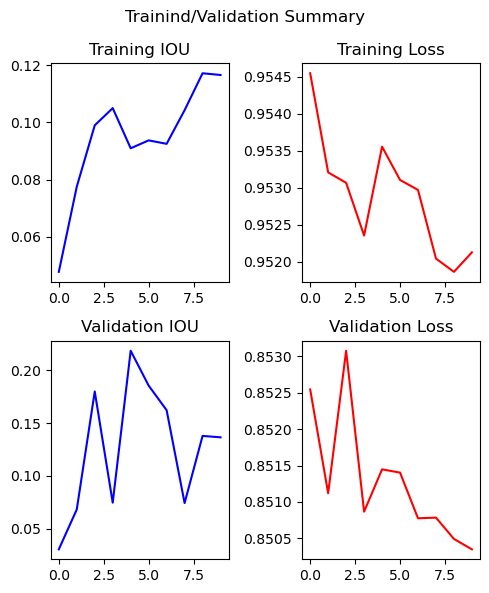

In [166]:
fig, axs = plt.subplots(2, 2, figsize=(5, 6))

axs[0, 0].plot(trainIOU, c='blue')
axs[0, 0].set_title("Training IOU")

axs[0, 1].plot(train_loss, c='red')
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(valIOU, c='blue')
axs[1, 0].set_title("Validation IOU")

axs[1, 1].plot(val_loss, c='red')
axs[1, 1].set_title("Validation Loss")

fig.suptitle('Trainind/Validation Summary')
fig.tight_layout()
fig.show()


In [210]:
def show_sample(model, data,n=2,threshold=0.6):
  imgs, true_masks = data
  results = model(imgs.to(device).float()).cpu()
  results = torch.where(results >= threshold, 1.0, 0.0) #where prob gt threshold set rgb values to 1 - turns colour white, else 0 for black
#   results = torch.tensor(results)

  fig, axs = plt.subplots(3, n, figsize=(n*3, 9))
  for i in range(n):
      axs[0, i].imshow(imgs[i].permute(1,2,0))
      axs[0, i].set_title("Input Image")

      axs[1, i].imshow(results[i].permute(1,2,0))
      axs[1, i].set_title("Predicted Mask")

      axs[2, i].imshow(true_masks[i].permute(1,2,0))
      axs[2, i].set_title("True Mask")
  fig.suptitle('Results Sample')
  fig.tight_layout()
  fig.show()

  return results

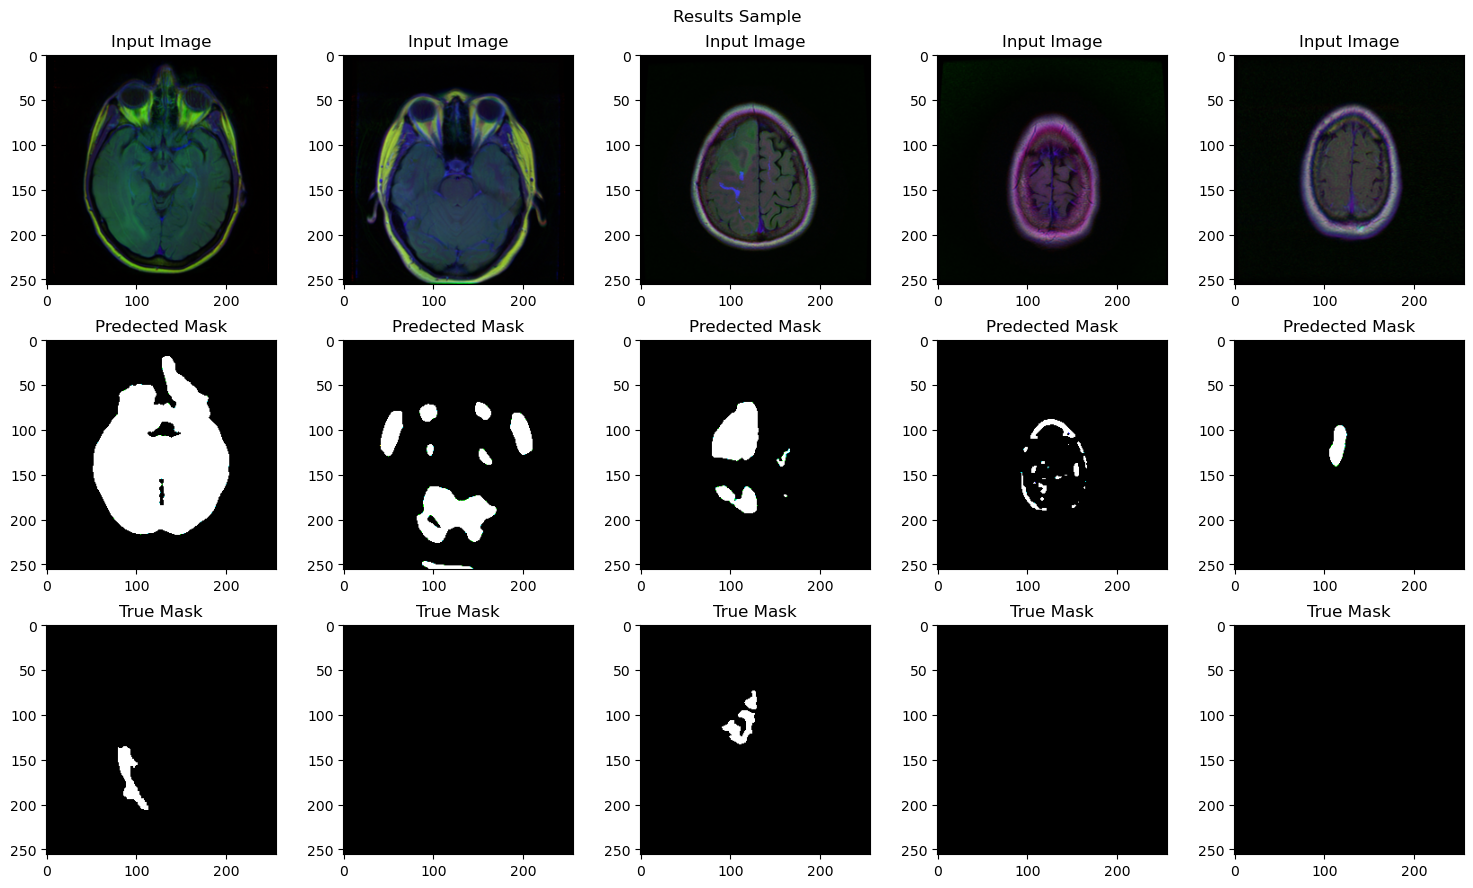

In [169]:
show_sample(model, next(iter(test_dataloader)), 5, threshold=0.6)

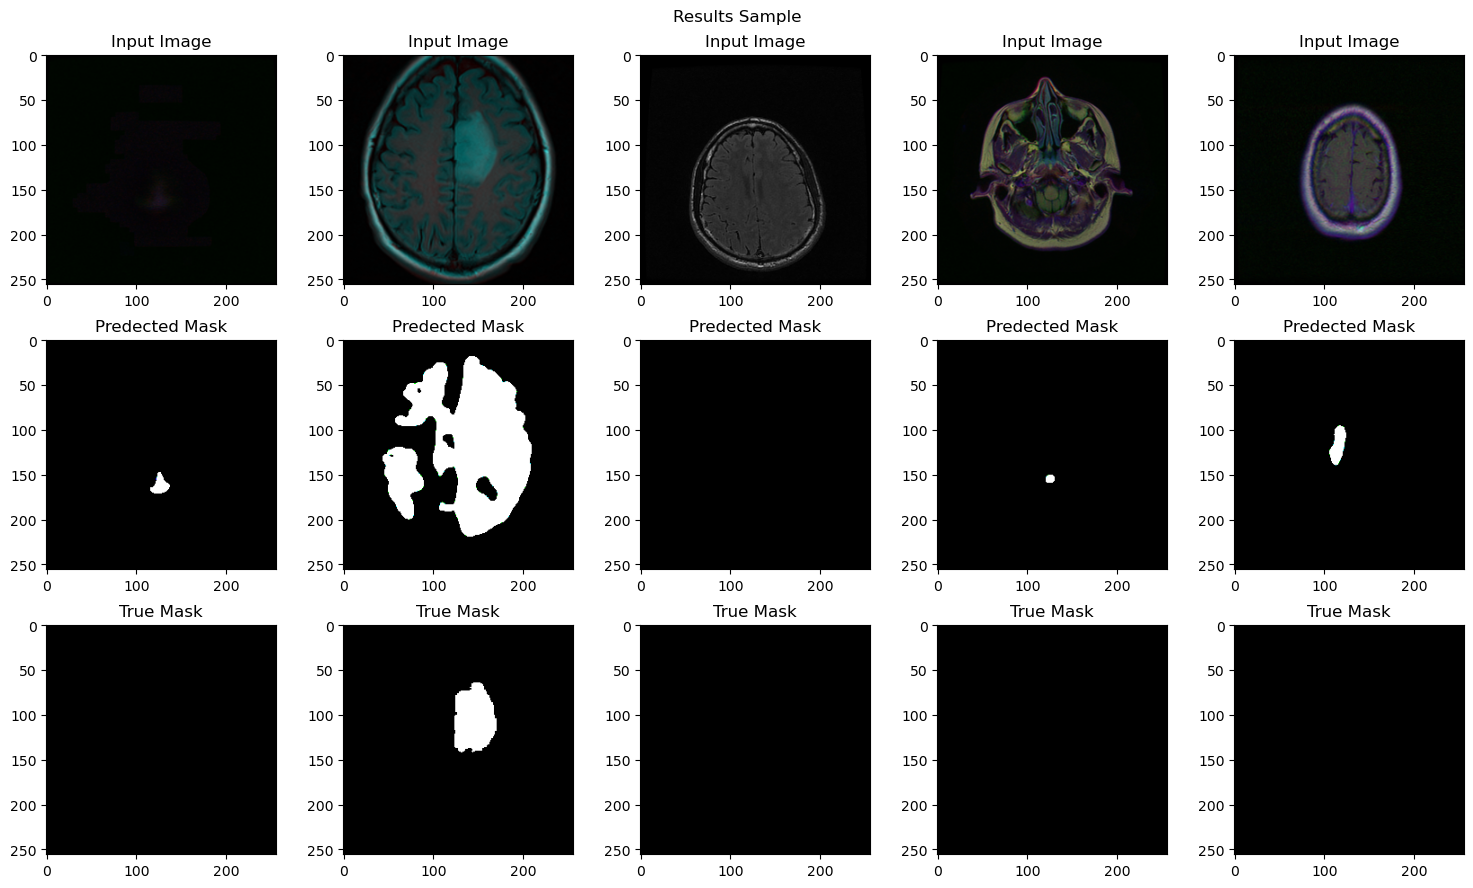

In [171]:
show_sample(model, next(iter(test_dataloader)), 5, threshold=0.95)

In [172]:
model_load = torch.load('model_test.pth')

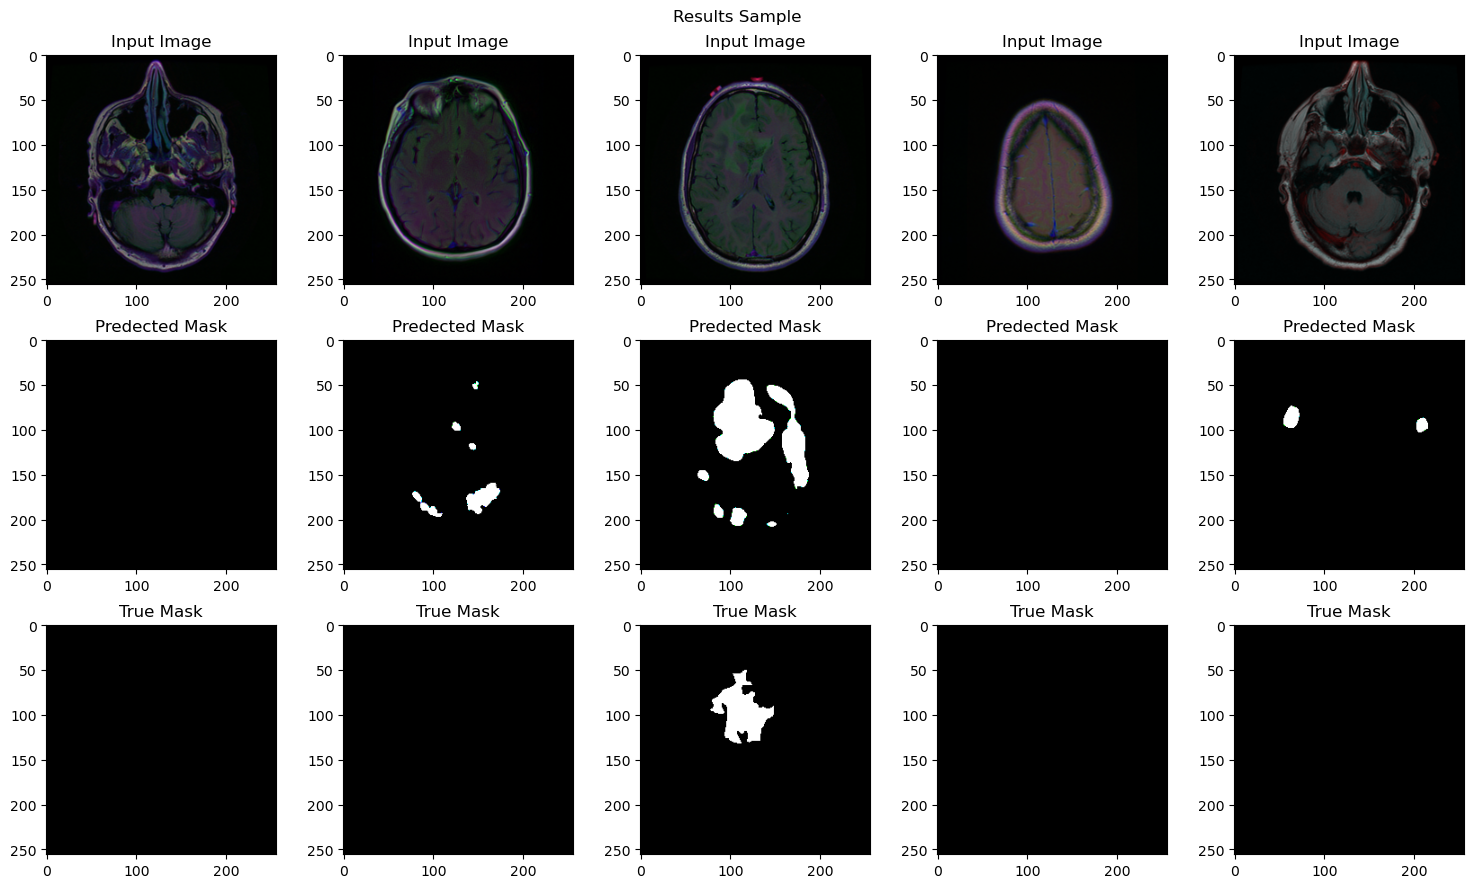

In [180]:
results = show_sample(model_load, next(iter(test_dataloader)), 5, threshold=0.95)

In [182]:
results.shape

torch.Size([64, 3, 256, 256])

In [183]:
results[0].shape

torch.Size([3, 256, 256])

In [185]:
imgs, true_masks = next(iter(test_dataloader))
results_prob = model_load(imgs.to(device).float()).cpu()

In [188]:
results[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [187]:
results_prob[0]

tensor([[[1.2787e-03, 1.4928e-05, 1.8451e-05,  ..., 1.3582e-05,
          9.5444e-06, 9.7185e-04],
         [2.1626e-05, 5.1181e-07, 5.9704e-07,  ..., 4.7223e-07,
          3.7268e-07, 1.3190e-05],
         [1.6514e-05, 4.5762e-07, 5.6318e-07,  ..., 4.2892e-07,
          3.0898e-07, 8.7602e-06],
         ...,
         [7.5748e-06, 2.7965e-07, 2.9792e-07,  ..., 2.7287e-07,
          2.3290e-07, 5.4702e-06],
         [5.3455e-06, 2.2169e-07, 2.0115e-07,  ..., 1.9571e-07,
          2.0147e-07, 4.7540e-06],
         [8.3967e-04, 7.2609e-06, 5.0624e-06,  ..., 4.8282e-06,
          6.3615e-06, 7.9713e-04]],

        [[1.0731e-03, 1.8577e-05, 2.3257e-05,  ..., 1.7608e-05,
          1.2361e-05, 8.8950e-04],
         [2.7177e-05, 9.1734e-07, 1.0811e-06,  ..., 8.6908e-07,
          6.8039e-07, 1.7499e-05],
         [2.1546e-05, 8.3803e-07, 1.0528e-06,  ..., 8.1412e-07,
          5.8067e-07, 1.2097e-05],
         ...,
         [1.0678e-05, 5.3554e-07, 5.8096e-07,  ..., 5.3536e-07,
          4.474

In [190]:
results[0].shape

torch.Size([3, 256, 256])

In [197]:
results[0][:, 0, 0].sum().item()

0.0

In [204]:
results[0][:, 0, 0].sum().item() != 0

False

In [217]:
num_pixels = 0

for j in range(256):
    for i in range(256):
        if (results[4][:, i, j].sum().item() > 0.0) & (results[4][:, i, j].sum().item() < 1.0):
            print(results[4][:, i, j])
            num_pixels += 1

In [218]:
num_pixels

0